# Seminário prático - Experimentos sobre meta-aprendizado

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from importlib import reload
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, accuracy_score

import aux
from aux import preprocess_default, ALL_ACC, ALL_ACC_SET, \
    drop_draw_set_class, drop_all_vs_rf, print_counter, \
    show_metrics, show_most_important_features
from itertools import combinations
from sklearn.metrics import precision_recall_fscore_support

In [16]:
data = pd.read_csv("meta-base.csv")
data

,general.attrToInst,general.catToNum,general.freqClass.mean,general.freqClass.sd,general.instToAttr,general.nrAttr,general.nrBin,general.nrCat,general.nrClass,general.nrInst,...,C4.5.auc,kNN.acc,kNN.f1m,kNN.auc,SVM.acc,SVM.f1m,SVM.auc,RF.acc,RF.f1m,RF.auc
0,0.100000,0.000000,0.5,0.471405,10.000000,60,0,0,2,600,...,0.993992,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.042056,0.000000,0.5,0.204863,23.777778,9,0,0,2,214,...,0.786753,0.789214,0.764841,0.879050,0.770022,0.733372,0.835946,0.848485,0.822825,0.916196
2,0.121622,5.000000,0.5,0.066888,8.222222,18,9,15,2,148,...,0.813973,0.807071,0.803779,0.887428,0.846863,0.843160,0.927110,0.866887,0.861265,0.941109
3,0.492063,0.148148,0.5,0.145911,2.032258,31,0,4,2,63,...,0.662129,0.663429,0.680036,0.749489,0.761619,0.750802,0.827020,0.785238,0.771251,0.833724
4,0.020833,0.000000,0.5,0.105224,48.000000,7,2,0,2,336,...,0.959853,0.942531,0.941450,0.977326,0.966627,0.965831,0.985190,0.965199,0.964476,0.987683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.223881,0.071429,0.5,0.158307,4.466667,15,1,1,2,67,...,0.779784,0.768214,0.757795,0.843975,0.697202,0.701777,0.808815,0.798333,0.784645,0.858558
396,0.003472,0.000000,0.5,0.283170,288.000000,6,0,6,2,1728,...,0.982767,0.877835,0.844500,0.955360,0.957931,0.950636,0.993741,0.989701,0.987869,0.999346
397,0.021277,0.000000,0.5,0.342688,47.000000,18,0,0,2,846,...,0.969553,0.970795,0.962234,0.993139,0.979193,0.972641,0.996332,0.986998,0.982835,0.998817
398,0.023500,0.000000,0.5,0.565685,42.553191,47,0,0,2,2000,...,0.981546,0.993950,0.983220,0.998558,0.994550,0.984556,0.999174,0.988250,0.965376,0.998578


# Primeiro experimento - 5 Classes

In [17]:
#remove as colunas referentes às medidas f1m e auc
data.drop(data.filter(regex='(.*?\.auc|.*?\.f1m)').columns, axis=1, inplace=True)
data.loc[:, ['landmarking.randomNode.sd', 'landmarking.worstNode.mean', 'landmarking.worstNode.sd', 'ANN.acc', 
             'C4.5.acc', 'kNN.acc', 'SVM.acc', 'RF.acc']]

,landmarking.randomNode.sd,landmarking.worstNode.mean,landmarking.worstNode.sd,ANN.acc,C4.5.acc,kNN.acc,SVM.acc,RF.acc
0,0.038789,0.886667,0.041425,1.000000,0.992000,1.000000,1.000000,1.000000
1,0.089963,0.617662,0.076761,0.708379,0.784846,0.789214,0.770022,0.848485
2,0.123754,0.560536,0.119251,0.837292,0.792357,0.807071,0.846863,0.866887
3,0.160420,0.639048,0.171734,0.767238,0.646000,0.663429,0.761619,0.785238
4,0.110580,0.604069,0.075009,0.961919,0.949307,0.942531,0.966627,0.965199
...,...,...,...,...,...,...,...,...
395,0.160472,0.636310,0.179899,0.770893,0.765179,0.768214,0.697202,0.798333
396,0.018734,0.700249,0.018734,0.999768,0.950167,0.877835,0.957931,0.989701
397,0.041359,0.742169,0.042820,0.982605,0.962633,0.970795,0.979193,0.986998
398,0.008433,0.900000,0.000000,0.994850,0.983450,0.993950,0.994550,0.988250


In [18]:
#remove as amostras com empate (com relação à maior acurácia) e determina as classes
data = drop_draw_set_class(data.copy())
data.loc[:, ['landmarking.randomNode.mean', 'landmarking.randomNode.sd', 'landmarking.worstNode.mean', 'landmarking.worstNode.sd', 'Class']]

,landmarking.randomNode.mean,landmarking.randomNode.sd,landmarking.worstNode.mean,landmarking.worstNode.sd,Class
0,0.655297,0.089963,0.617662,0.076761,RF.acc
1,0.593000,0.123754,0.560536,0.119251,RF.acc
2,0.569762,0.160420,0.639048,0.171734,RF.acc
3,0.674139,0.110580,0.604069,0.075009,SVM.acc
4,0.648228,0.142807,0.643772,0.147598,ANN.acc
...,...,...,...,...,...
378,0.676190,0.160472,0.636310,0.179899,RF.acc
379,0.700249,0.018734,0.700249,0.018734,ANN.acc
380,0.752254,0.041359,0.742169,0.042820,RF.acc
381,0.903000,0.008433,0.900000,0.000000,ANN.acc


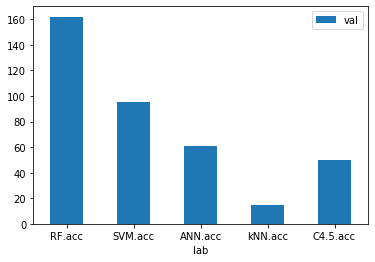

In [19]:
#plota distribuição das classes
X = data.drop('Class', axis=1)
y = data['Class']

vec = list(zip( *[*Counter( y ).items()])) 
gambs = pd.DataFrame(dict(zip(['lab', 'val'],vec))) 
ax = gambs.plot.bar(x='lab', y='val', rot=0) 
plt.show(block=True)

Fold  0  Id:  0
accuracy: 0.421875
precision:  0.24031746031746032
recall:  0.25644063180827886
f1_score:  0.2192982456140351
precision_recall_fscore_support : 
	
	[0.         0.33333333 0.56666667 0.3015873  0.        ]
	[0.         0.05882353 0.62962963 0.59375    0.        ]
	[0.         0.1        0.59649123 0.4        0.        ]
	[20 17 54 32  5]
Confusion matrix


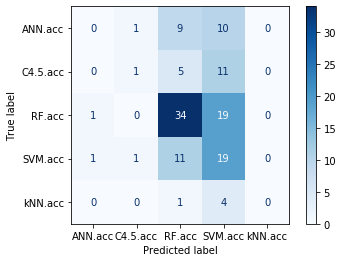


 

Fold  1  Id:  1
accuracy: 0.4765625
precision:  0.29764705882352943
recall:  0.31491285403050107
f1_score:  0.30214754098360663
precision_recall_fscore_support : 
	
	[0.4        0.125      0.58823529 0.375      0.        ]
	[0.4        0.05882353 0.74074074 0.375      0.        ]
	[0.4       0.08      0.6557377 0.375     0.       ]
	[20 17 54 32  5]
Confusion matrix


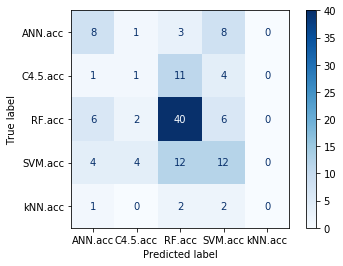


 

Fold  2  Id:  2
accuracy: 0.4881889763779528
precision:  0.28649068322981364
recall:  0.2803891449052739
f1_score:  0.2623275180080776
precision_recall_fscore_support : 
	
	[0.28571429 0.         0.52173913 0.625      0.        ]
	[0.19047619 0.         0.88888889 0.32258065 0.        ]
	[0.22857143 0.         0.65753425 0.42553191 0.        ]
	[21 16 54 31  5]
Confusion matrix


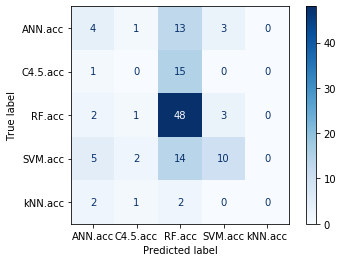


 

------------------------
Considered classes : All 

Mean accuracy =  0.0 



In [20]:
#aplicação do algoritmo Random Forest usando 3-folds cross validation seguido da avaliação das predições

rfc = RandomForestClassifier(n_estimators=200)
k = 0
acc = 0
acc_sum = 0   
n_splits = 3

skf = StratifiedKFold(n_splits=n_splits)
features_list = []
iii = 0
for k, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold ", k, " Id: ", iii)
    iii += 1
    rfc.fit(X.loc[train_index, :].drop('index', axis=1), y.loc[train_index])
    features_list.append(rfc.feature_importances_)
    y_pred = rfc.predict(X.loc[test_index, :].drop('index', axis=1), )
    
    show_metrics(y_true=y.loc[test_index], y_pred=y_pred)
    #matriz de confusão
    print("Confusion matrix")  
    disp = plot_confusion_matrix(rfc, X.loc[test_index, :].drop('index', axis=1), y.loc[test_index],
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    plt.show()
    print("\n \n")

#printa as médias das medidas tiradas nos 10 folds
print("------------------------")
print("Considered classes : All \n")
print("Mean accuracy = ", acc_sum / n_splits, "\n")

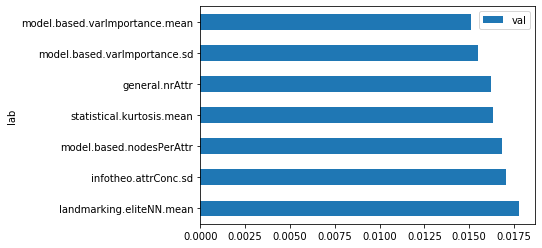

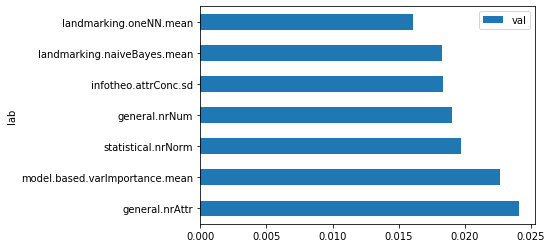

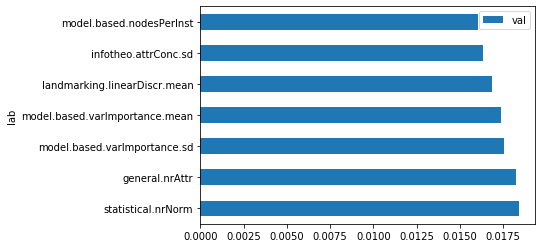

In [22]:
#exibe as características mais informativas da base em cada fold
show_most_important_features(X, features_list=features_list)


# Segundo experimento - Classes dois a dois

Considered classes
RF.acc -> 246
SVM.acc -> 151


Fold  0  Id:  0
accuracy: 0.45112781954887216
precision:  0.5035191441441441
recall:  0.50298900047824
f1_score:  0.44497799119647863
precision_recall_fscore_support : 
	
	[0.62162162 0.38541667]
	[0.2804878 0.7254902]
	[0.38655462 0.50340136]
	[82 51]


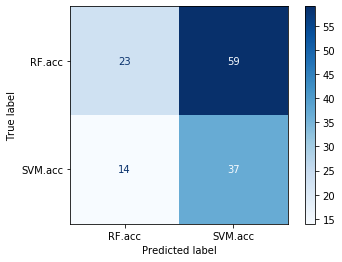


 

Fold  1  Id:  1
accuracy: 0.696969696969697
precision:  0.7013888888888888
recall:  0.6273170731707317
f1_score:  0.6244665718349929
precision_recall_fscore_support : 
	
	[0.69444444 0.70833333]
	[0.91463415 0.34      ]
	[0.78947368 0.45945946]
	[82 50]


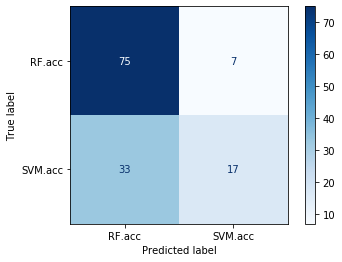


 

Fold  2  Id:  2
accuracy: 0.6818181818181818
precision:  0.6988304093567251
recall:  0.5995121951219512
f1_score:  0.5840336134453782
precision_recall_fscore_support : 
	
	[0.6754386  0.72222222]
	[0.93902439 0.26      ]
	[0.78571429 0.38235294]
	[82 50]


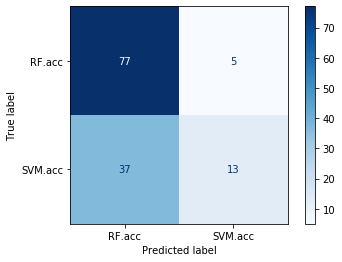


 

Mean accuracy =  0.6099718994455836 

-----------------------

Considered classes
RF.acc -> 304
C4.5.acc -> 89


Fold  0  Id:  3
accuracy: 0.7557251908396947
precision:  0.5776515151515151
recall:  0.5346517917511833
f1_score:  0.5279279279279279
precision_recall_fscore_support : 
	
	[0.36363636 0.79166667]
	[0.13793103 0.93137255]
	[0.2        0.85585586]
	[ 29 102]


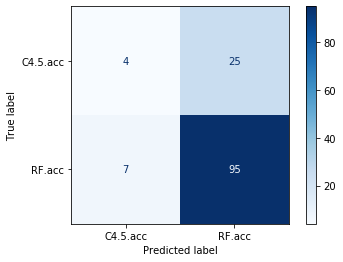


 

Fold  1  Id:  4
accuracy: 0.7557251908396947
precision:  0.6032913165266106
recall:  0.5486798679867987
f1_score:  0.5463203463203463
precision_recall_fscore_support : 
	
	[0.41666667 0.78991597]
	[0.16666667 0.93069307]
	[0.23809524 0.85454545]
	[ 30 101]


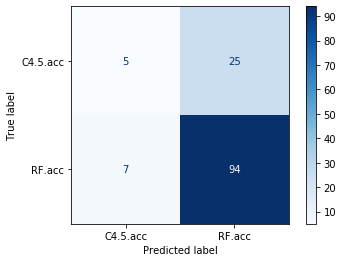


 

Fold  2  Id:  5
accuracy: 0.7633587786259542
precision:  0.6341954022988505
recall:  0.5770627062706271
f1_score:  0.5841269841269842
precision_recall_fscore_support : 
	
	[0.46666667 0.80172414]
	[0.23333333 0.92079208]
	[0.31111111 0.85714286]
	[ 30 101]


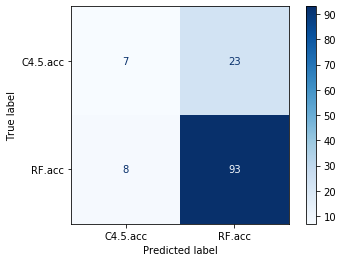


 

Mean accuracy =  0.7582697201017812 

-----------------------

Considered classes
SVM.acc -> 230
C4.5.acc -> 165


Fold  0  Id:  6
accuracy: 0.6363636363636364
precision:  0.7533875338753387
recall:  0.5662337662337662
f1_score:  0.5049999999999999
precision_recall_fscore_support : 
	
	[0.88888889 0.61788618]
	[0.14545455 0.98701299]
	[0.25 0.76]
	[55 77]


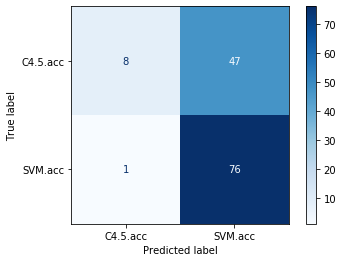


 

Fold  1  Id:  7
accuracy: 0.696969696969697
precision:  0.6883116883116883
recall:  0.6883116883116883
f1_score:  0.6883116883116883
precision_recall_fscore_support : 
	
	[0.63636364 0.74025974]
	[0.63636364 0.74025974]
	[0.63636364 0.74025974]
	[55 77]


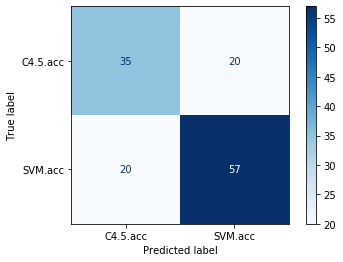


 

Fold  2  Id:  8
accuracy: 0.6412213740458015
precision:  0.7076365663322185
recall:  0.6782296650717703
f1_score:  0.6357882283348122
precision_recall_fscore_support : 
	
	[0.54347826 0.87179487]
	[0.90909091 0.44736842]
	[0.68027211 0.59130435]
	[55 76]


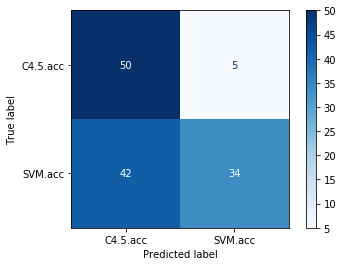


 

Mean accuracy =  0.6581849024597116 

-----------------------

Considered classes
RF.acc -> 347
kNN.acc -> 49


Fold  0  Id:  9
accuracy: 0.8712121212121212
precision:  0.4389312977099237
recall:  0.4956896551724138
f1_score:  0.46558704453441296
precision_recall_fscore_support : 
	
	[0.8778626 0.       ]
	[0.99137931 0.        ]
	[0.93117409 0.        ]
	[116  16]


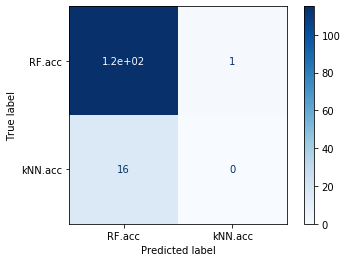


 

Fold  1  Id:  10
accuracy: 0.8787878787878788
precision:  0.6923076923076923
recall:  0.5269396551724138
f1_score:  0.5230352303523035
precision_recall_fscore_support : 
	
	[0.88461538 0.5       ]
	[0.99137931 0.0625    ]
	[0.93495935 0.11111111]
	[116  16]


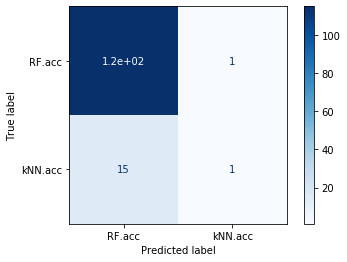


 

Fold  2  Id:  11
accuracy: 0.8787878787878788
precision:  0.7448818897637794
recall:  0.579539641943734
f1_score:  0.6033057851239669
precision_recall_fscore_support : 
	
	[0.88976378 0.6       ]
	[0.9826087  0.17647059]
	[0.9338843  0.27272727]
	[115  17]


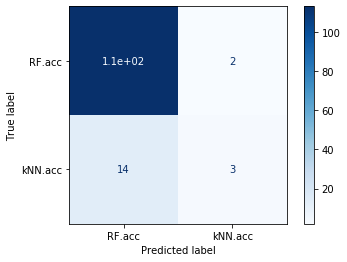


 

Mean accuracy =  0.8762626262626263 

-----------------------

Considered classes
kNN.acc -> 79
SVM.acc -> 317


Fold  0  Id:  12
accuracy: 0.75
precision:  0.6041666666666667
recall:  0.5952380952380952
f1_score:  0.5990057995028998
precision_recall_fscore_support : 
	
	[0.83333333 0.375     ]
	[0.85714286 0.33333333]
	[0.84507042 0.35294118]
	[105  27]


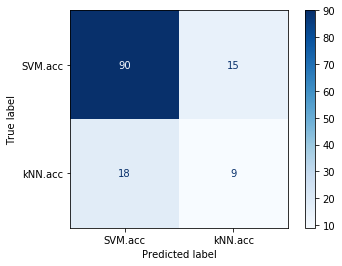


 

Fold  1  Id:  13
accuracy: 0.8409090909090909
precision:  0.8485714285714285
recall:  0.6106676342525399
f1_score:  0.6363636363636364
precision_recall_fscore_support : 
	
	[0.84       0.85714286]
	[0.99056604 0.23076923]
	[0.90909091 0.36363636]
	[106  26]


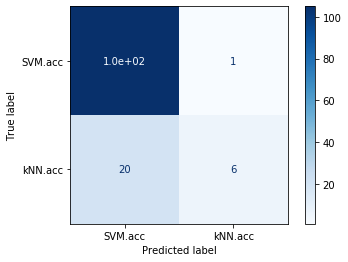


 

Fold  2  Id:  14
accuracy: 0.8181818181818182
precision:  0.78515625
recall:  0.5529753265602322
f1_score:  0.5487179487179488
precision_recall_fscore_support : 
	
	[0.8203125 0.75     ]
	[0.99056604 0.11538462]
	[0.8974359 0.2      ]
	[106  26]


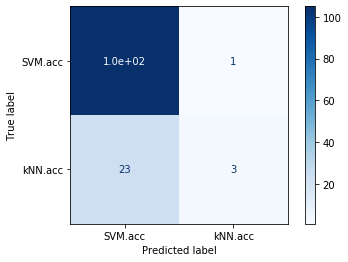


 

Mean accuracy =  0.8030303030303031 

-----------------------

Considered classes
kNN.acc -> 120
C4.5.acc -> 277


Fold  0  Id:  15
accuracy: 0.6541353383458647
precision:  0.6308045977011494
recall:  0.6529569892473118
f1_score:  0.6284013605442176
precision_recall_fscore_support : 
	
	[0.81333333 0.44827586]
	[0.65591398 0.65      ]
	[0.72619048 0.53061224]
	[93 40]


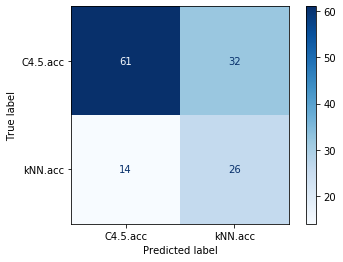


 

Fold  1  Id:  16
accuracy: 0.75
precision:  0.7312020460358056
recall:  0.6228260869565218
f1_score:  0.6308161708619374
precision_recall_fscore_support : 
	
	[0.75652174 0.70588235]
	[0.94565217 0.3       ]
	[0.84057971 0.42105263]
	[92 40]


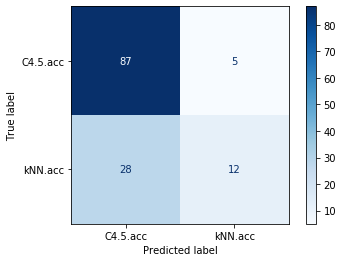


 

Fold  2  Id:  17
accuracy: 0.75
precision:  0.78099173553719
recall:  0.6016304347826087
f1_score:  0.5990057995028997
precision_recall_fscore_support : 
	
	[0.74380165 0.81818182]
	[0.97826087 0.225     ]
	[0.84507042 0.35294118]
	[92 40]


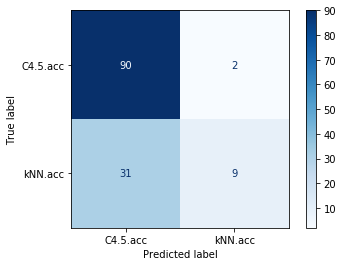


 

Mean accuracy =  0.7180451127819549 

-----------------------

Considered classes
RF.acc -> 271
ANN.acc -> 118


Fold  0  Id:  18
accuracy: 0.7
precision:  0.6065573770491803
recall:  0.5293040293040293
f1_score:  0.49355708720407554
precision_recall_fscore_support : 
	
	[0.5        0.71311475]
	[0.1025641  0.95604396]
	[0.17021277 0.81690141]
	[39 91]


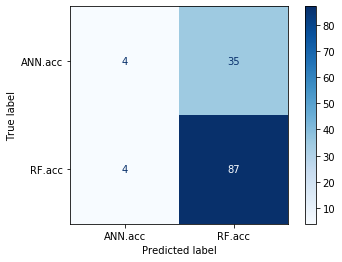


 

Fold  1  Id:  19
accuracy: 0.676923076923077
precision:  0.5840909090909091
recall:  0.5513888888888889
f1_score:  0.5449999999999999
precision_recall_fscore_support : 
	
	[0.45       0.71818182]
	[0.225      0.87777778]
	[0.3  0.79]
	[40 90]


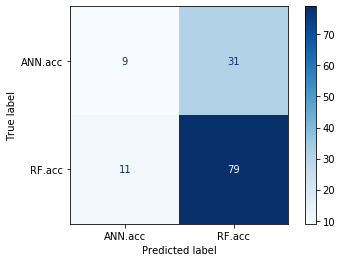


 

Fold  2  Id:  20
accuracy: 0.7209302325581395
precision:  0.6601307189542484
recall:  0.6256410256410256
f1_score:  0.6335227272727273
precision_recall_fscore_support : 
	
	[0.55555556 0.76470588]
	[0.38461538 0.86666667]
	[0.45454545 0.8125    ]
	[39 90]


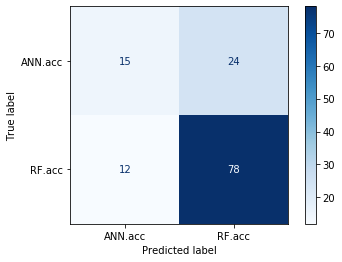


 

Mean accuracy =  0.6992844364937388 

-----------------------

Considered classes
SVM.acc -> 225
ANN.acc -> 170


Fold  0  Id:  21
accuracy: 0.6212121212121212
precision:  0.687136393018746
recall:  0.5677192982456141
f1_score:  0.5139911634756995
precision_recall_fscore_support : 
	
	[0.76923077 0.60504202]
	[0.1754386 0.96     ]
	[0.28571429 0.74226804]
	[57 75]


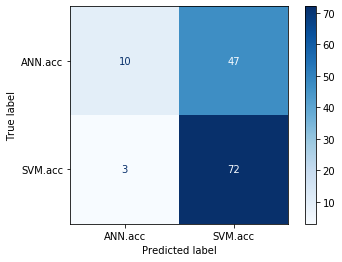


 

Fold  1  Id:  22
accuracy: 0.6136363636363636
precision:  0.6047008547008548
recall:  0.6031578947368421
f1_score:  0.6036036036036035
precision_recall_fscore_support : 
	
	[0.55555556 0.65384615]
	[0.52631579 0.68      ]
	[0.54054054 0.66666667]
	[57 75]


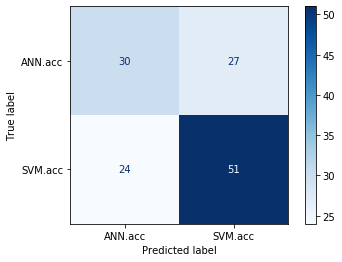


 

Fold  2  Id:  23
accuracy: 0.5114503816793893
precision:  0.7333333333333334
recall:  0.5733333333333334
f1_score:  0.44608879492600423
precision_recall_fscore_support : 
	
	[0.46666667 1.        ]
	[1.         0.14666667]
	[0.63636364 0.25581395]
	[56 75]


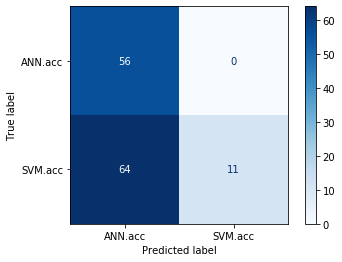


 

Mean accuracy =  0.5820996221759581 

-----------------------

Considered classes
ANN.acc -> 214
C4.5.acc -> 178


Fold  0  Id:  24
accuracy: 0.6259541984732825
precision:  0.624883395522388
recall:  0.6260593220338984
f1_score:  0.6245540153243259
precision_recall_fscore_support : 
	
	[0.67164179 0.578125  ]
	[0.625      0.62711864]
	[0.64748201 0.60162602]
	[72 59]


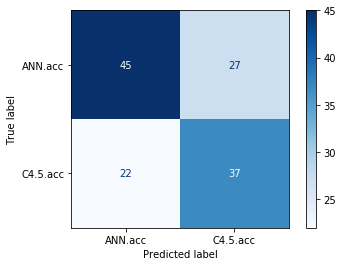


 

Fold  1  Id:  25
accuracy: 0.6946564885496184
precision:  0.6998721227621483
recall:  0.6834507042253521
f1_score:  0.683115626511853
precision_recall_fscore_support : 
	
	[0.68235294 0.7173913 ]
	[0.81690141 0.55      ]
	[0.74358974 0.62264151]
	[71 60]


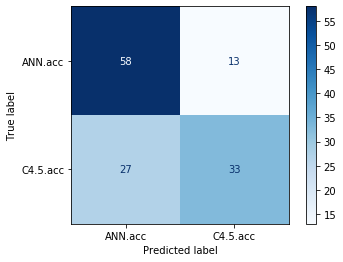


 

Fold  2  Id:  26
accuracy: 0.7153846153846154
precision:  0.7371281464530892
recall:  0.6978992599665792
f1_score:  0.6957814180001265
precision_recall_fscore_support : 
	
	[0.68478261 0.78947368]
	[0.88732394 0.50847458]
	[0.77300613 0.6185567 ]
	[71 59]


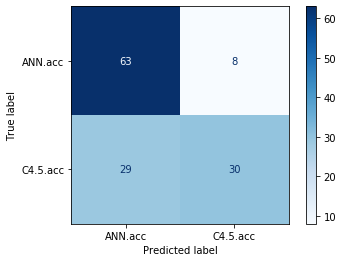


 

Mean accuracy =  0.6786651008025054 

-----------------------

Considered classes
kNN.acc -> 82
ANN.acc -> 313


Fold  0  Id:  27
accuracy: 0.6287878787878788
precision:  0.5585197934595525
recall:  0.5817307692307692
f1_score:  0.5508021390374331
precision_recall_fscore_support : 
	
	[0.8313253  0.28571429]
	[0.66346154 0.5       ]
	[0.73796791 0.36363636]
	[104  28]


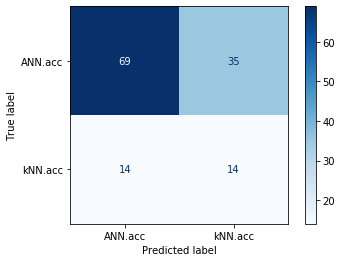


 

Fold  1  Id:  28
accuracy: 0.8106060606060606
precision:  0.78125
recall:  0.5507936507936508
f1_score:  0.5431261248788593
precision_recall_fscore_support : 
	
	[0.8125 0.75  ]
	[0.99047619 0.11111111]
	[0.89270386 0.19354839]
	[105  27]


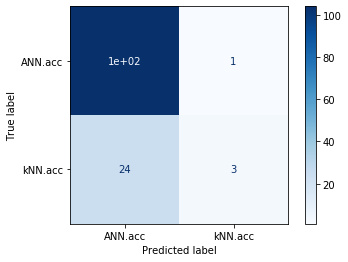


 

Fold  2  Id:  29
accuracy: 0.7938931297709924
precision:  0.3969465648854962
recall:  0.5
f1_score:  0.4425531914893617
precision_recall_fscore_support : 
	
	[0.79389313 0.        ]
	[1. 0.]
	[0.88510638 0.        ]
	[104  27]


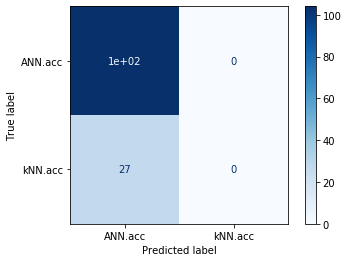


 

Mean accuracy =  0.7444290230549773 

-----------------------



In [8]:
from sklearn.metrics import precision_recall_fscore_support
reload(aux)
comb_to_drop = list(combinations(ALL_ACC, r=3))
raw = pd.read_csv('meta-base.csv')

features_list = []
acc_mean_list = []
#para cada combinação de 3 colunas, dropa essas 3 deixando 2 colunas para o problema de classificação
#faz o pre_processamento do dataframe passando as colunas consideradas
# (retira os empates e seta as classes)
# divide o data em features e rótulo e divide os folds
iii = 0
for to_drop in comb_to_drop:
    data = raw.drop(list(to_drop), axis=1)
    considered_classes = ALL_ACC_SET - set(to_drop)
    data = preprocess_default(data, list(considered_classes))
    rfc = RandomForestClassifier(n_estimators=200)
    X = data.drop('Class', axis=1)
    y = data['Class']
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits)
    acc_list = []
    print("Considered classes")
    print_counter(y)
    print("\n")
    
    for k, (train_index, test_index) in enumerate(skf.split(X, y)):
        print("Fold ", k, " Id: ", iii)
        iii += 1
        rfc.fit(X.loc[train_index, :], y.loc[train_index])
        features_list.append(rfc.feature_importances_)
        y_pred = rfc.predict(X.loc[test_index, :], )
        
        acc_list.append(accuracy_score(y_true=y.loc[test_index], y_pred=y_pred))
        
        aux.show_metrics(y_true=y.loc[test_index], y_pred=y_pred)
        
        #matriz de confusão
        disp = plot_confusion_matrix(rfc, X.loc[test_index, :], y.loc[test_index],
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
        plt.show()
        print("\n \n")

    print("Mean accuracy = ", np.mean(acc_list) , "\n")
    acc_mean_list.append(np.mean(acc_list))
    print("-----------------------\n")
 
    

25 é das mais balanceadas (ANN x C4.5)


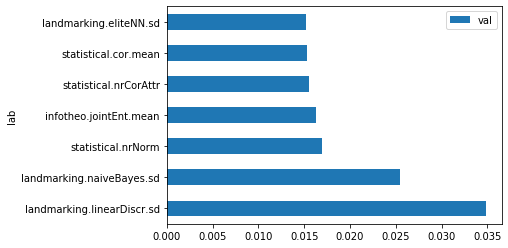

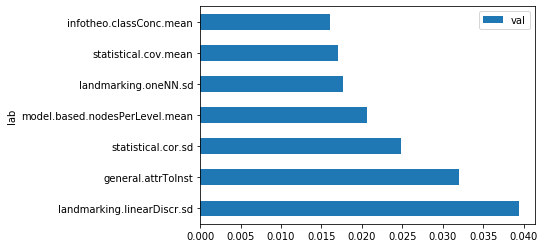

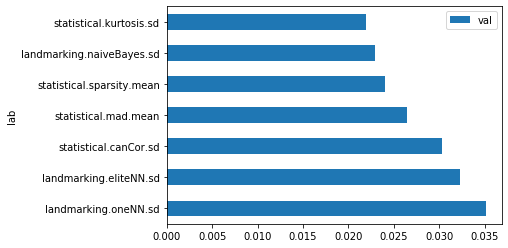

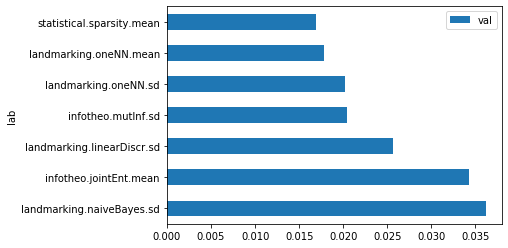

In [9]:
best_matrix = [7, 8, 24, 25]

show_most_important_features(
    X, map(lambda x: features_list[x], best_matrix)
)

print("25 é das mais balanceadas (ANN x C4.5)")

14 é das mais DESBALANCEADAS (ANN x C4.5)


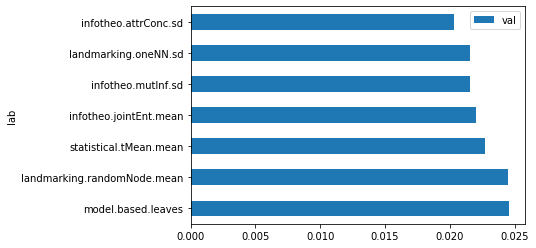

In [10]:
worst_matrix = [14]

show_most_important_features(
    X, map(lambda x: features_list[x], worst_matrix)
)
print("14 é das mais DESBALANCEADAS (ANN x C4.5)")

# Terceiro experimento - Random Forest x Outros

Considered classes
RF.acc -> 162
Other -> 221


Fold  0  Id:  0
accuracy: 0.6493506493506493
precision:  0.6403061224489796
recall:  0.6325757575757576
f1_score:  0.6335272342675833
precision_recall_fscore_support : 
	
	[0.67346939 0.60714286]
	[0.75       0.51515152]
	[0.70967742 0.55737705]
	[44 33]


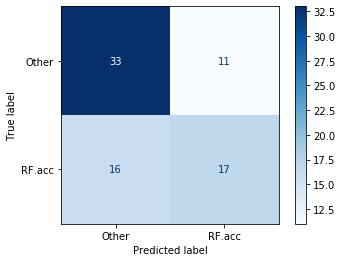


 

Fold  1  Id:  1
accuracy: 0.7792207792207793
precision:  0.7806122448979591
recall:  0.7651515151515151
f1_score:  0.7692578882425524
precision_recall_fscore_support : 
	
	[0.7755102  0.78571429]
	[0.86363636 0.66666667]
	[0.8172043  0.72131148]
	[44 33]


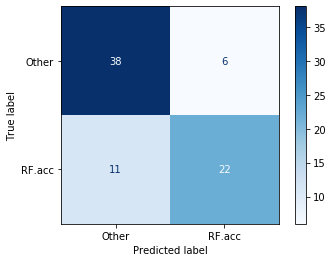


 

Fold  2  Id:  2
accuracy: 0.7142857142857143
precision:  0.7126572327044025
recall:  0.6878472222222223
f1_score:  0.6913265306122449
precision_recall_fscore_support : 
	
	[0.71698113 0.70833333]
	[0.84444444 0.53125   ]
	[0.7755102  0.60714286]
	[45 32]


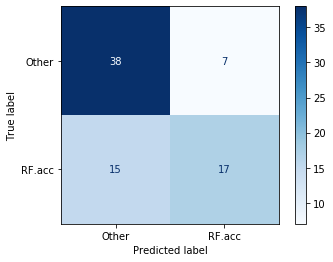


 

Fold  3  Id:  3
accuracy: 0.6973684210526315
precision:  0.6929411764705883
recall:  0.6747159090909092
f1_score:  0.6771929824561403
precision_recall_fscore_support : 
	
	[0.70588235 0.68      ]
	[0.81818182 0.53125   ]
	[0.75789474 0.59649123]
	[44 32]


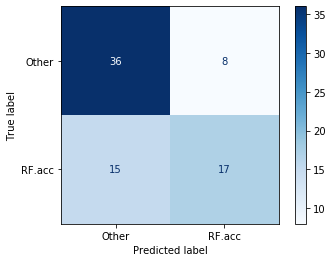


 

Fold  4  Id:  4
accuracy: 0.6710526315789473
precision:  0.661408657373441
recall:  0.65625
f1_score:  0.6577193298504775
precision_recall_fscore_support : 
	
	[0.70212766 0.62068966]
	[0.75   0.5625]
	[0.72527473 0.59016393]
	[44 32]


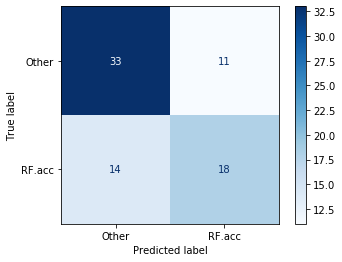


 

Mean accuracy =  0.7022556390977444 

-----------------------



In [11]:
data_rf_all = drop_all_vs_rf(pd.read_csv('meta-base.csv'))
data_rf_all.drop(data_rf_all.filter(regex='(.*?\.auc|.*?\.f1m)').columns, axis=1, inplace=True)

#para cada combinação de 3 colunas, dropa essas 3 deixando 2 colunas para o problema de classificação
#faz o pre_processamento do dataframe passando as colunas consideradas (retira os empates e seta as classes)
#divide o data em features e rótulo e divide os folds
data = data_rf_all
rfc = RandomForestClassifier(n_estimators=1000)
X = data.drop('Class', axis=1)
y = data['Class']
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=42,
                      shuffle=True)
acc_list = []
print("Considered classes")
print_counter(y)
print("\n")
iii = 0
for k, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold ", k, " Id: ", iii)
    iii += 1    
    rfc.fit(X.loc[train_index, :], y.loc[train_index])
    features_list.append(rfc.feature_importances_)
    y_pred = rfc.predict(X.loc[test_index, :], )
    
    acc_list.append(accuracy_score(y_true=y.loc[test_index], y_pred=y_pred))

    aux.show_metrics(y_true=y.loc[test_index], y_pred=y_pred)
    
    #matriz de confusão
    disp = plot_confusion_matrix(rfc, X.loc[test_index, :], y.loc[test_index],
                             display_labels=None,
                             cmap=plt.cm.Blues,
                             normalize=None)
    plt.show()
    print("\n \n")

print("Mean accuracy = ", np.mean(acc_list), "\n")
print("-----------------------\n")


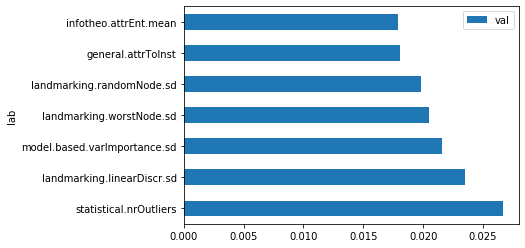

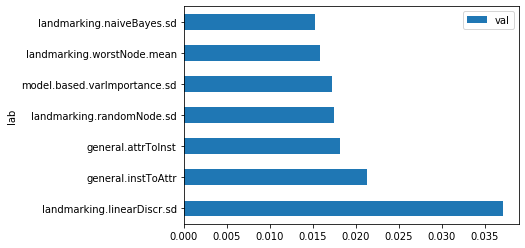

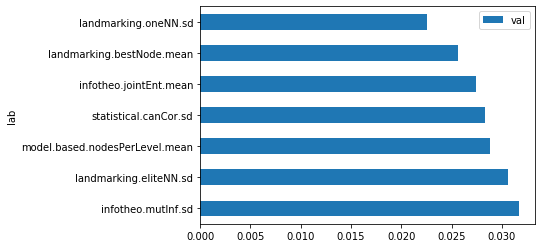

In [12]:
matrix = [1, 2, 3]

show_most_important_features(
    X, map(lambda x: features_list[x], matrix)
)